# Can 4 output neurons classify 10 classes?

The first chapter of the <a href = "http://neuralnetworksanddeeplearning.com/chap1.html" target="_blank">"Neural Networks and Deep Learning"</a> book by Michael Nielsen teaches how to use neural networks to classify images in the MNIST dataset. While reading this chapter, a paragraph caught my eye.

:::{admonition} <a href = "http://neuralnetworksanddeeplearning.com/chap1.html" target="_blank">Source</a>
:class: tip
 "You might wonder why we use $10$ output neurons. After all, the goal of the network
is to tell us which digit $(0,1,2,. . .,9)$ corresponds to the input image. A seemingly natural
way of doing that is <span style= "color:#E83E8C;">to use just $4$ output neurons, treating each neuron as taking on a binary
value, depending on whether the neuron’s output is closer to $0$ or to $1$.</span> Four neurons are
enough to encode the answer, since $2^4 = 16$ is more than the $10$ possible values for the input
digit. Why should our network use $10$ neurons instead? Isn’t that inefficient?"
:::

In this article we shall implement a neural network with just $4$ neurons to classify $10$ classes, using the above idea. <span style= "color:#E83E8C;">Can sigmoid perform multi-class classification?</span> Hold that thought!

<hr>

**This article:**
<ol style = "line-height:180%;">
    <li>Implements 4-neuron image classification model for MNIST dataset.</li>
<li>Provides reasons for difference in performance of above model and the baseline 10 neuron model.</li>
    <li>Extends the implementation of 4-neuron model to 16 classes.</li>
    <li>Explains reasons, possible heuristics for difference in performances.</li>
    </ol>
    
<hr>

## Introduction

Our goal here is to perform Image Classification on the MNIST dataset using a neural network. Before proceeding to the code, this section discusses how neural networks learn.

### Perceptron:

A perceptron takes in several binary inputs, $x_1, x_2, x_3,...,$ and produces a single binary output:

:::{figure-md} markdown-fig
<img src="images/perceptron.png">

 Perceptron
:::


A simple way is introduced to find the output of perceptron. We assign weights,$w_1, w_2, w_3,...,$ to each input expressing the importance of respective inputs to the output. The perceptron's output, $0$ or $1$, is determined by whether the weighted sum $\sum_j w_jx_j$ is less than or greater than some <span style= "color:#E83E8C;">threshold</span> value. This equation can be re-written by introducing a bias term $b$ and classifying if the total sum is greater than $0$ or less than $0$. This is explained below in algebraic terms:

$$\begin{eqnarray}
  \mbox{output} & = & \left\{ \begin{array}{ll}
      0 & \mbox{if } \sum_j w_j x_j +b \leq 0 \\
      1 & \mbox{if } \sum_j w_j x_j +b > 0
      \end{array} \right.
\end{eqnarray}$$

The perceptron can be thought as a unit that makes decisions by weighing up evidence.

### Sigmoid Neuron:

The above form of perceptron has multiple caveats. We do not have control over the bias term $b$ as it can take any value on the number line as the numeric size of inputs changes. Additionally, a small change in the inputs can cause the perceptron to completely flip the class from $0$ to $1$. This leads to poor performance of model while training. To overcome this problem, the sum from the output is fed to a <span style= "color:#E83E8C;">sigmoid function.</span> This function is also called <span style= "color:#E83E8C;">an activation function</span>. Sigmoid functions takes any number and gives an output between $0$ and $1$. Hence $0.5$ can be used as a threshold to classify classes based on the output from sigmoid function.

$$\sigma(z) = \frac{1}{1+e^{-z}}$$

$$\text{output from sigmoid} = \frac{1}{1+\text{exp}(-\sum_jw_jx_j - b)}$$

<p style="text-align:center"><img src="images/sigmoid_step.PNG" height = "250px" width = "550px"/></p>

The above image compares the sigmoid function with the Step function. Sigmoid is a smoothed version of step function. Step-function can be considered to represent the perceptron except for $x=0$.

### Learning process:

The smoothness introduced by the sigmoid function has a crucial advantage. The smoothness of $\sigma$ means that small changes $\Delta w_j$ in the weights and $\Delta b$ in the bias will produce a small change $\Delta \text{output}$ in the output from the neuron. The algebraic form is given by:

$$\Delta \text{output} \approx \sum_j\frac{\partial \text{ output}}{\partial w_j}\Delta w_j+\frac{\partial\text{ output}}{\partial b}\Delta b$$

For example, suppose the network was mistaken classifying an image as an “8” when it should be a “9”. We could figure out how to make a small change in the weights and biases so the network gets a little closer to classifying the image as a “9”. And then we’d repeat this, changing the weights and biases over and over to produce better and better output. The network would be learning.

<span style= "color:#E83E8C;">This is an high-level overview of the learning process.</span> More details about the learning process and backpropagation algorithm are saved for a future article.

### Softmax neurons:

Softmax activation function comes into picture usually in the case of multi-class classficiation. Softmax outputs the probability of each class given an (image) input. The important difference between sigmoid and softmax function is that while sigmoid function outputs <span style= "color:#E83E8C;">confidence index of one class</span> in binary classification, softmax provides the probability of each class.

In the case of sigmoid it is interpreted that the likelihood of a class occuring in image is proportional to the value of sigmoid function but not exactly equal to the output. This leads to the fact that softmax activation function uses categorical cross-entropy loss with equal number of neurons as the number of classes.

## Encoding image labels:

<span style= "color:#E83E8C; font-weight:bold;">This section is the core component of this article.</span>

Using binary cross-entropy loss and Sigmoid activation function gives us an output between $0$ and $1$. If $4$ such neurons are placed in the output layer of a neural network, the network yields $2$ possible outputs for every neuron. Hence we shall have $2^4=16$ outputs, which are more than sufficient to classify $10$ classes.

We achieve this encoding by converting the class labels in terms of <span style= "color:#E83E8C;">Binary Numbers</span>. For example $9$ can be encoded and re-labelled to $1001$. This allows us the required classification. Keep in mind the binary cross-entropy loss function because when each neuron is concerned it's still a binary classification between $0$ and $1$.

**The rest of the article is the python code implementing this above idea. Feel free to run this notebook in colab to edit code in real time using the rocket <i class="fa fa-rocket" aria-hidden="true"></i> icon on the top of the page.**

In [12]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist, fashion_mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from sklearn.utils import shuffle

In [13]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

A look at how the images are present in the dataset. Click on the right "+" icon to see the code.

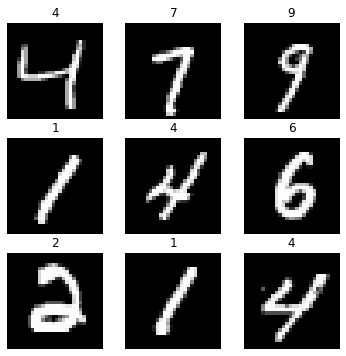

In [14]:
fig = plt.figure(figsize=(6, 6))

columns =3
rows = 3
axes = []

# printing 16 training images
for i in range(1, columns*rows +1):
    idx = np.random.randint(1, 100)
    img = X_train[idx]
    axes.append(fig.add_subplot(rows, columns, i))
    subplot_title = y_train[idx]
    axes[-1].set_title(subplot_title)
    plt.imshow(img, interpolation='nearest', cmap=plt.get_cmap('gray'))
    plt.axis('off')
    
plt.show()

**The below functions are used to encode image labels to binary number format.**

In [15]:
def decimalToBinary(n):
    # converting decimal to binary
    # and removing the prefix(0b)
    test = bin(n).replace("0b", "")
    if len(test)<4:
        test = '0'*(4-len(test))+test
    return test

cache_y_train= [decimalToBinary(num) for num in y_train]
cache_y_test = [decimalToBinary(num) for num in y_test]

def final_conversion(array):
    final = []
    for i in array:
        split = []
        for j in i:
            split.append(float(j))
        final.append(np.array(split))
    return np.array(final)

y_train_custom = final_conversion(cache_y_train)
y_test_custom = final_conversion(cache_y_test)

print(len(y_train_custom))
print(len(y_test_custom))

60000
10000


Data normalization and one-hot encoding for the baseline model with $10$ neurons.

In [16]:
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape((X_train.shape[0], num_pixels)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], num_pixels)).astype('float32')
X_train = X_train / 255
X_test = X_test / 255

# one hot encode outputs
y_train_baseline = np_utils.to_categorical(y_train)
y_test_baseline = np_utils.to_categorical(y_test)

In [17]:
# train and validation data splits

train_size = int(X_train.shape[0] * 0.9)

train_img, valid_img = X_train[ : train_size], X_train[train_size : ]
train_label_custom, valid_label_custom = y_train_custom[ : train_size], y_train_custom[train_size : ]
train_label_baseline, valid_label_baseline = y_train_baseline[ : train_size], y_train_baseline[train_size : ]

In [18]:
train_img[0].shape

(784,)

In [19]:
def four_neuron_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [20]:
model = four_neuron_model()

# Fit the model
model.fit(train_img, train_label_custom,
          validation_data=(valid_img, valid_label_custom), 
          epochs=5, batch_size=200, verbose = 2)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test_custom, verbose=0)
print("\n Four Neuron model Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/5
270/270 - 5s - loss: 0.1689 - accuracy: 0.5509 - val_loss: 0.0783 - val_accuracy: 0.5587 - 5s/epoch - 17ms/step
Epoch 2/5
270/270 - 4s - loss: 0.0739 - accuracy: 0.5794 - val_loss: 0.0635 - val_accuracy: 0.6058 - 4s/epoch - 14ms/step
Epoch 3/5
270/270 - 4s - loss: 0.0525 - accuracy: 0.5795 - val_loss: 0.0466 - val_accuracy: 0.5748 - 4s/epoch - 14ms/step
Epoch 4/5
270/270 - 4s - loss: 0.0407 - accuracy: 0.5849 - val_loss: 0.0427 - val_accuracy: 0.6192 - 4s/epoch - 13ms/step
Epoch 5/5
270/270 - 3s - loss: 0.0323 - accuracy: 0.5906 - val_loss: 0.0413 - val_accuracy: 0.6082 - 3s/epoch - 13ms/step

 Four Neuron model Error: 37.61%


In [21]:
baseline = baseline_model()

# Fit the model
baseline.fit(train_img, train_label_baseline,
             validation_data=(valid_img, valid_label_baseline),
             epochs=5, batch_size=200, verbose=2)

# Final evaluation of the model
scores = baseline.evaluate(X_test, y_test_baseline, verbose=0)
print("\n Baseline model Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/5
270/270 - 5s - loss: 0.2962 - accuracy: 0.9157 - val_loss: 0.1294 - val_accuracy: 0.9653 - 5s/epoch - 17ms/step
Epoch 2/5
270/270 - 4s - loss: 0.1199 - accuracy: 0.9659 - val_loss: 0.0938 - val_accuracy: 0.9715 - 4s/epoch - 14ms/step
Epoch 3/5
270/270 - 4s - loss: 0.0773 - accuracy: 0.9783 - val_loss: 0.0733 - val_accuracy: 0.9795 - 4s/epoch - 14ms/step
Epoch 4/5
270/270 - 4s - loss: 0.0545 - accuracy: 0.9846 - val_loss: 0.0712 - val_accuracy: 0.9792 - 4s/epoch - 14ms/step
Epoch 5/5
270/270 - 4s - loss: 0.0393 - accuracy: 0.9889 - val_loss: 0.0694 - val_accuracy: 0.9800 - 4s/epoch - 13ms/step

 Baseline model Error: 2.38%


In [22]:
#code to re-convert binary numbers to decimals to interpret the results
def decode(array):
    final = ''
    for i in array:
        final+=str(int(i))
    return int(final,2)

In [ ]:
fig = plt.figure(figsize=(8, 8))

columns = 4
rows = 4
axes = []

np.random.seed(10)
# printing 16 training images
for i in range(1, columns*rows +1):
    idx = np.random.randint(1, 100)
    img = X_test[idx]
    img1 = img.reshape(28,28)
    img_tensor = np.expand_dims(img, axis=0)
    axes.append(fig.add_subplot(rows, columns, i))
    subplot_title = decode(np.round(model.predict(img_tensor)[0]))
    axes[-1].set_title(subplot_title)
    plt.imshow(img1, interpolation='nearest', cmap=plt.get_cmap('gray'))
    plt.axis('off')
    
fig.suptitle('4 neuron model predictions!', fontsize = 16)    
plt.show()

fig2 = plt.figure(figsize=(8, 8))

columns2 = 4
rows2 = 4
axes2 = []

print("\n")
np.random.seed(10)
# printing 16 training images
for i in range(1, columns2*rows2 +1):
    idx = np.random.randint(1, 100)
    img = X_test[idx]
    img1 = img.reshape(28,28)
    img_tensor = np.expand_dims(img, axis=0)
    axes.append(fig2.add_subplot(rows, columns, i))
    subplot_title = np.argmax(baseline.predict(img_tensor))
    axes[-1].set_title(subplot_title)
    plt.imshow(img1, interpolation='nearest', cmap=plt.get_cmap('gray'))
    plt.axis('off')

fig2.suptitle('Baseline model predictions!', fontsize = 16) 
plt.show()

<table><tr>
<td> 
  <p align="center" style="padding: 10px">
    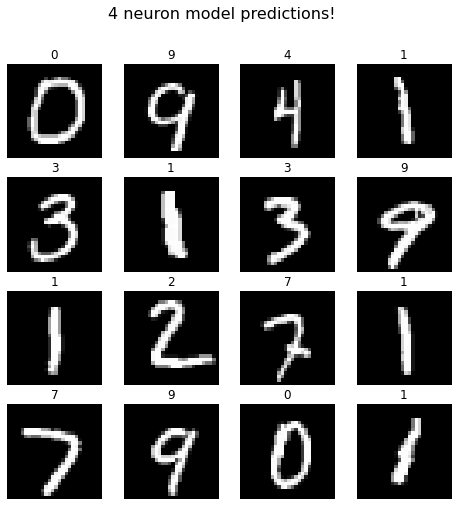
    <br>
  </p> 
</td>
<td> 
  <p align="center">
    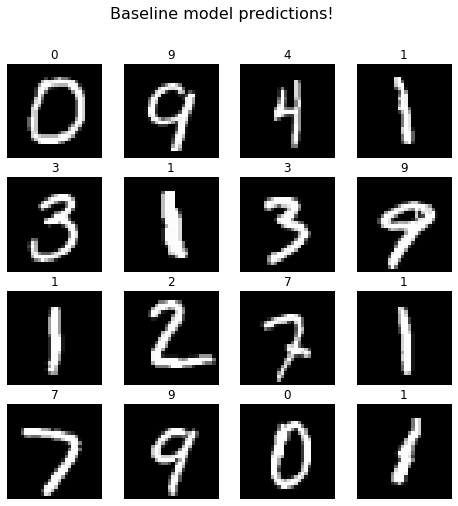
    <br>
  </p> 
</td>
</tr></table>

## Results discussion and Inference: Part-1

The above image shows the performance of 4-neuron-model with binary crossentropy loss as compared to the baseline 10-neuron-model with categorical crossentropy.

<span style= "color:#E83E8C;">1. What is the reason for reduced accuracy of the 4-neuron-model although 4 neurons are sufficient to encode the labels?</span>

While the 4 neurons are sufficient to encode all the $10$ labels, the neurons are not sufficient to uniquely represent the features of all the classes. Let's dive a little deep into this inference.

Consider the first neuron in the output layer. Suppose this neuron learns the features to decide if the number in the image is a $0$. For the sake of intuition lets suppose each neuron is reponsible for ${\frac{1}{4}}^{th}$ of the image. Hence for the number $0$ all the neurons learn their representations. However, if we had 4 outputs, then the first output neuron would be trying to decide what the most significant bit of the digit was. And there’s no easy way to relate that most significant bit to simple shapes like those shown above.

<p style="text-align:center"><img src="images/mnist_zero.PNG"/></p>

In other words, there are no sufficient neurons to capture the representations (features) of all the image labels individually. All the neurons work simultaneously for every image class and thus have a poorer representation as a whole as compared to 10 neurons with softmax activation (where each class is uniquely represented by each neuron in terms of probability.)

## Extending the 4-neuron-model to 16 classes

After implementing a 4-neuron-model for $10$ classes, let's extend the code to work for $16$ classes. One thing to keep in mind before proceeding with the code is the size of the images. All the images must be of the same size during training. This can be done using image processing, but I felt it would be the best find a dataset with the same dimensions as MNIST.

Luckily, there is the **fashion-mnist dataset** with $28 \times 28$ images. Hence, we can combine the two datasets for $16$ classes

In [23]:
#Loading MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#Loading Fashion MNIST dataset
(X_train1, y_train1), (X_test1, y_test1) = fashion_mnist.load_data()

In [24]:
fashion_x_train = []
fashion_y_train = []

for i in range(len(y_train1)):
    if y_train1[i] in [0,1,2,3,4,5]:
        fashion_x_train.append(X_train1[i])
        fashion_y_train.append(y_train1[i]+10)
        
fashion_x_train = np.array(fashion_x_train)
fashion_y_train = np.array(fashion_y_train)

print(fashion_x_train.shape)
print(fashion_y_train.shape)

fashion_x_test = []
fashion_y_test = []

for i in range(len(y_test1)):
    if y_test1[i] in [0,1,2,3,4,5]:
        fashion_x_test.append(X_test1[i])
        fashion_y_test.append(y_test1[i]+10)
        
fashion_x_test = np.array(fashion_x_test)
fashion_y_test = np.array(fashion_y_test)

print(fashion_x_test.shape)
print(fashion_y_test.shape)

(36000, 28, 28)
(36000,)
(6000, 28, 28)
(6000,)


In [25]:
train_array_x = np.concatenate((X_train, fashion_x_train), axis = 0)
train_array_y = np.concatenate((y_train, fashion_y_train), axis = 0)

test_array_x = np.concatenate((X_test, fashion_x_test), axis = 0)
test_array_y = np.concatenate((y_test, fashion_y_test), axis = 0)

final_dict = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9,
              10: 'T-Shirt',11: 'Trouser', 12: 'Pullover',
              13: 'Dress', 14: 'Coat', 15: 'Sandal'}

In [26]:
train_array_x, train_array_y = shuffle(train_array_x, train_array_y, random_state=0)
test_array_x, test_array_y = shuffle(test_array_x, test_array_y, random_state=0)

In [27]:
len(train_array_x)

96000

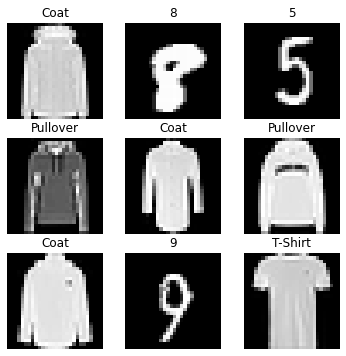

In [28]:
fig = plt.figure(figsize=(6,6))

columns =3
rows = 3
axes = []

# printing 16 training images
for i in range(1, columns*rows +1):
    idx = np.random.randint(1,100 )
    img = train_array_x[idx]
    axes.append(fig.add_subplot(rows, columns, i))
    subplot_title = final_dict[train_array_y[idx]]
    axes[-1].set_title(subplot_title)
    plt.imshow(img, interpolation='nearest', cmap=plt.get_cmap('gray'))
    plt.axis('off')
    
plt.show()

In [29]:
def decimalToBinary(n):
    # converting decimal to binary
    # and removing the prefix(0b)
    test = bin(n).replace("0b", "")
    if len(test)<4:
        test = '0'*(4-len(test))+test
    return test

cache_y_train= [decimalToBinary(num) for num in train_array_y]
cache_y_test = [decimalToBinary(num) for num in test_array_y]

def final_conversion(array):
    final = []
    for i in array:
        split = []
        for j in i:
            split.append(float(j))
        final.append(np.array(split))
    return np.array(final)

In [30]:
num_pixels = train_array_x.shape[1] * train_array_x.shape[2]

train_array_x = train_array_x.reshape((train_array_x.shape[0], num_pixels)).astype('float32')
test_array_x = test_array_x.reshape((test_array_x.shape[0], num_pixels)).astype('float32')

train_array_x = train_array_x / 255
test_array_x = test_array_x / 255

# one hot encode outputs
y_train_baseline = np_utils.to_categorical(train_array_y)
y_test_baseline = np_utils.to_categorical(test_array_y)

y_train_custom = final_conversion(cache_y_train)
y_test_custom = final_conversion(cache_y_test)

print(len(y_train_custom))
print(len(y_test_custom))

96000
16000


In [31]:
train_size = int(train_array_x.shape[0] * 0.9)

train_img, valid_img = train_array_x[ : train_size], train_array_x[train_size : ]
train_label_custom, valid_label_custom = y_train_custom[ : train_size], y_train_custom[train_size : ]
train_label_baseline, valid_label_baseline = y_train_baseline[ : train_size], y_train_baseline[train_size : ]

In [32]:
train_img[0].shape

(784,)

In [33]:
def four_neuron_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [34]:
import time
start_time = time.time()

model = four_neuron_model()

# Fit the model
history_four_nuerons = model.fit(train_img, train_label_custom,
                                 validation_data=(valid_img, valid_label_custom),
                                 epochs=5, batch_size=200, verbose=2)

# Final evaluation of the model
scores = model.evaluate(test_array_x, y_test_custom, verbose=0)
print("\nFour Neuron model Error: %.2f%%" % (100-scores[1]*100))

end_time = time.time()

print("Time taken for training: {} seconds".format(round(end_time-start_time,2)))

Epoch 1/5
432/432 - 7s - loss: 0.1596 - accuracy: 0.6714 - val_loss: 0.1030 - val_accuracy: 0.6709 - 7s/epoch - 16ms/step
Epoch 2/5
432/432 - 6s - loss: 0.0831 - accuracy: 0.7038 - val_loss: 0.0766 - val_accuracy: 0.7134 - 6s/epoch - 13ms/step
Epoch 3/5
432/432 - 6s - loss: 0.0662 - accuracy: 0.7086 - val_loss: 0.0702 - val_accuracy: 0.6980 - 6s/epoch - 13ms/step
Epoch 4/5
432/432 - 6s - loss: 0.0557 - accuracy: 0.7153 - val_loss: 0.0634 - val_accuracy: 0.7350 - 6s/epoch - 13ms/step
Epoch 5/5
432/432 - 6s - loss: 0.0490 - accuracy: 0.7161 - val_loss: 0.0617 - val_accuracy: 0.6908 - 6s/epoch - 13ms/step

Four Neuron model Error: 30.82%
Time taken for training: 32.89 seconds


In [35]:
import time
start_time = time.time()

baseline = baseline_model()

# Fit the model
history_baseline = baseline.fit(train_img, train_label_baseline,
                                validation_data=(valid_img, valid_label_baseline),
                                epochs=5, batch_size=200, verbose=2)

# Final evaluation of the model
scores = baseline.evaluate(test_array_x, y_test_baseline, verbose=0)
print("\nBaseline model Error: %.2f%%" % (100-scores[1]*100))

end_time = time.time()

print("Time taken for training: ", round(end_time-start_time,2))

Epoch 1/5
432/432 - 7s - loss: 0.3235 - accuracy: 0.9027 - val_loss: 0.2148 - val_accuracy: 0.9276 - 7s/epoch - 16ms/step
Epoch 2/5
432/432 - 6s - loss: 0.1713 - accuracy: 0.9444 - val_loss: 0.1629 - val_accuracy: 0.9454 - 6s/epoch - 14ms/step
Epoch 3/5
432/432 - 6s - loss: 0.1369 - accuracy: 0.9543 - val_loss: 0.1398 - val_accuracy: 0.9523 - 6s/epoch - 14ms/step
Epoch 4/5
432/432 - 6s - loss: 0.1143 - accuracy: 0.9611 - val_loss: 0.1350 - val_accuracy: 0.9552 - 6s/epoch - 14ms/step
Epoch 5/5
432/432 - 6s - loss: 0.0975 - accuracy: 0.9672 - val_loss: 0.1408 - val_accuracy: 0.9509 - 6s/epoch - 14ms/step

Baseline model Error: 5.10%
Time taken for training:  34.19


In [ ]:
fig = plt.figure(figsize=(8, 8))

columns = 4
rows = 4
axes = []

np.random.seed(10)
# printing 16 training images
for i in range(1, columns*rows +1):
    
    idx = np.random.randint(1, 100)
    img = test_array_x[idx]
    img1 = img.reshape(28,28)
    img_tensor = np.expand_dims(img, axis=0)
    axes.append(fig.add_subplot(rows, columns, i))
    subplot_title = final_dict[decode(np.round(model.predict(img_tensor)[0]))]
    axes[-1].set_title(subplot_title)
    plt.imshow(img1, interpolation='nearest', cmap=plt.get_cmap('gray'))
    plt.axis('off')
    
fig.suptitle('4 neuron model predictions!', fontsize = 16)    
plt.show()

fig2 = plt.figure(figsize=(8, 8))

columns2 = 4
rows2 = 4
axes2 = []

print("\n")

# printing 16 training images
np.random.seed(10)
for i in range(1, columns2*rows2 +1):
    idx = np.random.randint(1, 100)
    img = test_array_x[idx]
    img1 = img.reshape(28,28)
    img_tensor = np.expand_dims(img, axis=0)
    axes.append(fig2.add_subplot(rows, columns, i))
    subplot_title = final_dict[np.argmax(baseline.predict(img_tensor))]
    axes[-1].set_title(subplot_title)
    plt.imshow(img1, interpolation='nearest', cmap=plt.get_cmap('gray'))
    plt.axis('off')

fig2.suptitle('Baseline model predictions!', fontsize = 16) 
plt.show()

<table><tr>
<td> 
  <p align="center" style="padding: 10px">
    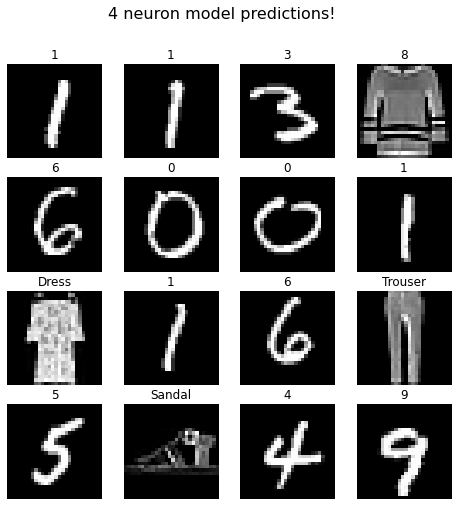
    <br>
  </p> 
</td>
<td> 
  <p align="center">
    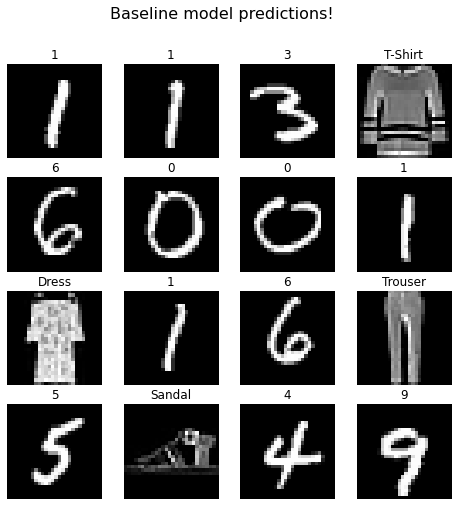
    <br>
  </p> 
</td>
</tr></table>

## Results discussion and Inference: Part-2

The above image shows the performance of 4-neuron-model with binary crossentropy loss (with 16 classes) as compared to the baseline 16-neuron-model with categorical crossentropy.

<span style= "color:#E83E8C;">2. What is the reason for increased accuracy of the 4-neuron-model for 16 classes compared to 10 classes?</span>

The answer is in the binary encoding of image labels. If you take a closer look at the binary encodings of numbers from $0$ to $9$, we see that $9$ is encoded as $1001$. This means the first digit ($1$) is not fired for all the other $9$ classes and is not really used during the training process.

On the flip side, when $16$ classes come into picture, all the $4$ neurons are used during training and have a better training/validation accuracy.

## Results discussion and Inference: Part-3

As a conclusion to this article lets take a look at instances where the 4-neuron-model and the baseline model have different predictions for the same image. Below is a picture showing a small sub-set of such instances.

_P.S. A gentle reminder that you can run the code in this article easily by using the rocket <i class="fa fa-rocket" aria-hidden="true"></i> icon on the top of the page._

<span style= "color:#E83E8C;">$4$ indicates the 4-neuron-model's prediction, b indicates the baseline model's prediction, A is the actual label of the instance under consideration.</span>

In [ ]:
test_array_short = test_array_x[:1000]
y_test_short = test_array_y[:1000]

model_predictions = model.predict(test_array_short)
baseline_predictions = baseline.predict(test_array_short)

model_predictions = np.array([final_dict[decode(np.round(i))] for i in model_predictions])
baseline_predictions = np.array([final_dict[np.argmax(i)] for i in baseline_predictions])

print(len(model_predictions))
print(len(baseline_predictions))

bool_array = model_predictions==baseline_predictions
final = np.argwhere(bool_array==False)

In [ ]:
fig2 = plt.figure(figsize=(12,12))

columns2 = 3
rows2 = 3
axes2 = []

print("\n")

# printing 16 training images
np.random.seed(10)
for i in range(1, columns2*rows2 +1):
    idx = random.sample(list(final),1)[0][0]
    img = test_array_short[idx]
    img1 = img.reshape(28,28)
    img_tensor = np.expand_dims(img, axis=0)
    axes.append(fig2.add_subplot(rows, columns, i))
    subplot_title = "4 -> {}, b -> {}, A -> {}".format(model_predictions[idx], baseline_predictions[idx], final_dict[test_array_y[idx]])
    axes[-1].set_title(subplot_title)
    plt.imshow(img1, interpolation='nearest', cmap=plt.get_cmap('gray'))
    plt.axis('off')
    
plt.show()

<p style="text-align:center"><img src="images/index_33_1.png"/></p>